# **Q/A chatbot with LLMs + Harry Potter**
# About
* Use Langchain to build a chatbot that can answer questions about Harry Potter books
* Experiment with various LLMs (Large Language Models)
* Use ***ChromaDB*** vector store to store text embeddings with ***Instructor-Finetuned Text Embeddings*** from Hugging Face
* Use ***Retrieval chain*** to retrieve relevant passages from embedded text
Summarize retrieved passages
* Chat UI with ***Gradio***
No need to create any API key to use this notebook! Everything is open source.

# Models

* WizardLM
* Falcon
* Llama 2-7b
* Llama 2-13b
* Bloom

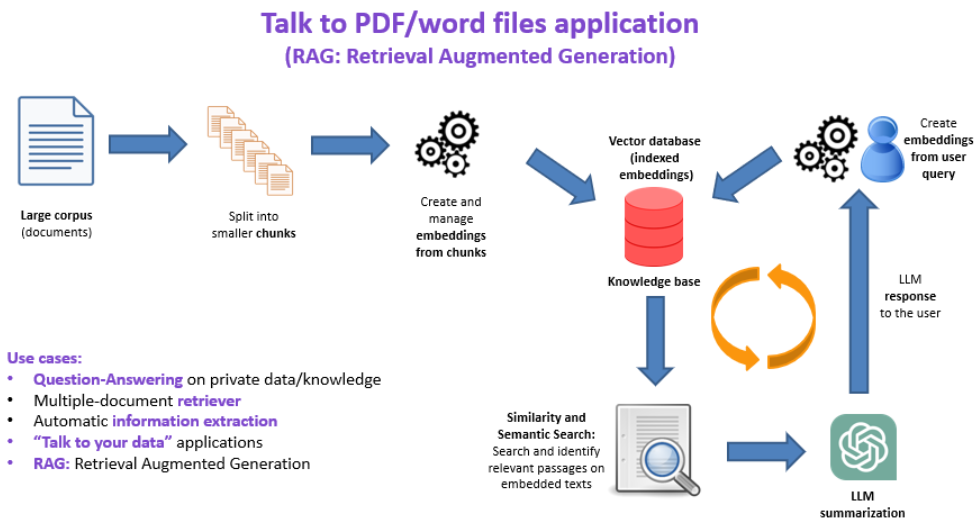

In [ ]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

In [1]:
! pip install accelerate
# ! pip install git+https://github.com/huggingface/accelerate
! pip3 install deepspeed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.1 MB/s eta 0:00:00


In [1]:
!pip install streamlit
! pip install --upgrade gradio -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 36.6 MB/s eta 0:00:00
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzlocal-5.0.1:
      Successfully uninstalled tzlocal-5.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 75.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.9 MB/s eta 0:00:00

In [2]:
! nvidia-smi -L # Check the usage of hardware

GPU 0: Tesla T4 (UUID: GPU-ade2935c-540d-781d-a8f1-d6eb5492704f)


In [2]:
# ! accelerate config

In [3]:
# ! accelerate env


In [3]:
!pip install transformers # This installs a very light version of 🤗 Transformers. In particular, no specific machine learning frameworks (like PyTorch or TensorFlow) are installed.
!pip install transformers[sentencepiece]



In [4]:
%%time

! pip install -qq -U langchain tiktoken pypdf chromadb faiss-gpu
! pip install -qq -U transformers InstructorEmbedding sentence_transformers
! pip install -qq -U accelerate bitsandbytes xformers einops

CPU times: user 101 ms, sys: 13.8 ms, total: 114 ms
Wall time: 16.7 s


# Imports

In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import textwrap
import time

import langchain

# loaders
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader

# splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

# prompts
from langchain import PromptTemplate, ConversationChain, LLMChain

# vector stores
from langchain.vectorstores import Chroma, FAISS

# models
from langchain.llms import HuggingFacePipeline
from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

# retrievers
from langchain.chains import RetrievalQA, ConversationalRetrievalChain

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

print(langchain.__version__)


[2023-08-18 07:07:35,877] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)
0.0.267


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

glob.glob('/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/*')

['/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 2 - The Chamber of Secrets.pdf',
 '/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 1 - The Sorcerers Stone.pdf',
 '/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf',
 '/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 3 - The Prisoner of Azkaban.pdf',
 '/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 5 - The Order of the Phoenix.pdf',
 '/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 7 - The Deathly Hallows.pdf',
 '/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 6 - The Half-Blood

# **CFG**
* CFG class enables easy and organized experimentation
** Refers to a class that represents a Context-Free Grammar (CFG). A Context-Free Grammar is a formal notation used in formal language theory to describe the syntax of programming languages, natural languages, and other structured languages.

In [8]:
class CFG:
    # LLMs
    model_name = 'llama2-13b' # wizardlm, bloom, falcon, llama2-7b, llama2-13b
    temperature = 0,
    top_p = 0.95,
    repetition_penalty = 1.15

    # splitting
    split_chunk_size = 800
    split_overlap = 0

    # embeddings
    embeddings_model_repo = 'hkunlp/instructor-base'

    # similar passages
    k = 3

    # paths
    PDFs_path = '/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/'
    Embeddings_path =  '/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/harry-potter-vectordb-chroma'
    Persist_directory = './harry-potter-vectordb-chroma'

# **Define model**

In [9]:
def get_model(model = CFG.model_name):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'wizardlm':
        model_repo = 'TheBloke/wizardLM-7B-HF'

        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
            )

        max_len = 1024

    elif model == 'llama2-7b':
        model_repo = 'daryl149/llama-2-7b-chat-hf'

        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
            )

        max_len = 2048

    elif model == 'llama2-13b':
        model_repo = 'daryl149/llama-2-13b-chat-hf'

        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
            )

        max_len = 8192

    elif model == 'bloom':
        model_repo = 'bigscience/bloom-7b1'

        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            )

        max_len = 1024

    elif model == 'falcon':
        model_repo = 'h2oai/h2ogpt-gm-oasst1-en-2048-falcon-7b-v2'

        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
            )

        max_len = 1024

    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len

In [10]:
%%time

tokenizer, model, max_len = get_model(model = CFG.model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 11.6 s, sys: 20.9 s, total: 32.5 s
Wall time: 2min 44s


# 🤗 **pipeline**
## Hugging Face pipeline


In [11]:
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
    max_length = max_len,
    temperature = CFG.temperature,
    top_p = CFG.top_p,
    repetition_penalty = CFG.repetition_penalty
)

llm = HuggingFacePipeline(pipeline = pipe)

In [12]:
llm

HuggingFacePipeline(cache=None, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x798520404be0>, model_id='gpt2', model_kwargs=None, pipeline_kwargs=None)

In [13]:
### testing model, not using the harry potter books yet
### answer is not necessarily related to harry potter
query = "Give me 5 examples of cool potions and explain what they do"
llm(query)


".\n\nSure thing! Here are five examples of cool potions in the world of Dungeons & Dragons, along with a brief description of their effects:\n\n1. Potion of Healing: This potion restores hit points to the drinker, healing wounds and injuries sustained during combat or other physical activities. It's a staple of many adventurers' inventories, as it can be used to recover from dangerous battles or long journeys.\n2. Potion of Invisibility: As its name suggests, this potion grants the drinker temporary invisibility, allowing them to move undetected and strike from unexpected angles. It's often used by rogues and assassins to slip past guards or gain an advantage in stealthy situations.\n3. Potion of Speed: This potion increases the drinker's speed for a short period of time, allowing them to move faster and cover more ground than normal. It's useful for races like halflings and gnomes, who already have high movement speeds, but can also be helpful for other classes that rely on mobility.

# 🦜🔗 Langchain
## Multiple document retriever with LangChain

In [14]:
CFG.model_name

'llama2-13b'

# Loader
## Directory loader for multiple files
## This step is not necessary if you are just loading the vector database
## This step is necessary if you are creating embeddings. In this case you need to:
  load de PDF files

*   List item
*   List item


  split into chunks
  create embeddings
  save the embeddings in a vector store
  After that you can just load the saved embeddings to do similarity search with the user query, and then use the LLM to answer the question

In [19]:
%%time

loader = DirectoryLoader(CFG.PDFs_path,
                         glob="./*.pdf",
                         loader_cls=PyPDFLoader,
                         show_progress=True,
                         use_multithreading=True)

documents = loader.load()

100%|██████████| 7/7 [01:18<00:00, 11.19s/it]

CPU times: user 1min 17s, sys: 1.33 s, total: 1min 19s
Wall time: 1min 18s


In [20]:
len(documents)


4114

In [21]:
documents[8].page_content


"8Ron\nP.S. Percy's Head Boy. He got the letter last week.Harry glanced back at the photograph. Percy, who was in his seventh and\nfinal year at Hogwarts, was looking particularly smug. He had pinned hisHead Boy badge to the fez perched jauntily on top of his neat hair, hishorn-rimmed glasses flashing in the Egyptian sun.\nHarry now turned to his present and unwrapped it. Inside was what looked\nlike a miniature glass spinning top. There was another note from Ronbeneath it.\nHarry -- this is a Pocket Sneakoscope. If there's someone untrustworthy\naround, it's supposed to light up and spin. Bill says it's rubbish soldfor wizard tourists and isn't reliable, because it kept lighting up atdinner last night. But he didn't realize Fred and George had put beetlesin his soup.\nBye --RonHarry put the Pocket Sneakoscope on his bedside table, where it stood\nquite still, balanced on its point, reflecting the luminous hands of hisclock. He looked at it happily for a few seconds, then picked up the

In [22]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = CFG.split_chunk_size,
                                               chunk_overlap = CFG.split_overlap)

texts = text_splitter.split_documents(documents)
len(texts)


10519

In [23]:
%%time

### download embeddings model
instructor_embeddings = HuggingFaceInstructEmbeddings(model_name = CFG.embeddings_model_repo,
                                                      model_kwargs = {"device": "cuda"})

### create embeddings and DB
vectordb = Chroma.from_documents(documents = texts,
                                 embedding = instructor_embeddings,
                                 persist_directory = CFG.Persist_directory,
                                 collection_name = 'hp_books')

# vectordb.add_documents(documents=texts, embedding=instructor_embeddings)

### persist Chroma vector database
vectordb.persist()

load INSTRUCTOR_Transformer
max_seq_length  512
CPU times: user 3min 18s, sys: 1.96 s, total: 3min 20s
Wall time: 3min 9s


In [24]:
### how many documents were loaded
print(vectordb._collection.count())

21038


In [25]:
prompt_template = """
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)

In [26]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(llm = llm,
                                       chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
                                       retriever = retriever,
                                       chain_type_kwargs = {"prompt": PROMPT},
                                       return_source_documents = True,
                                       verbose = False)

In [44]:
### testing MMR search
question = "Which are Hagrid's favorite animals?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)


[Document(page_content='CHAPTER  THIRTEEN \n\x91 198 \x91 nothing better than a pet drag on, as Harry, Ron, and Hermione \nknew only too well — he had owned one for a brief period during \ntheir first year, a vicious Norweg ian Ridgeback by the name of \nNorbert. Hagrid simply loved monstrous creatures, the more \nlethal, the better. \n“Well, at least the skrewts are sma ll,” said Ron as they made their \nway back up to the castle for lunch an hour later. \n“They are now, ” said Hermione in an exasperated voice, “but \nonce Hagrid’s found out what they eat, I expect they’ll be six feet \nlong.” \n“Well, that won’t matter if they turn out to cure seasickness or \nsomething, will it?” said Ro n, grinning slyly at her. \n“You know perfectly we ll I only said that to shut Malfoy up,”', metadata={'page': 213, 'source': '/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf'}),
 Document(page_content='97they 

In [43]:
### testing similarity search
question = "Which are Hagrid's favorite animals?"
vectordb.similarity_search(question, k = CFG.k)

[Document(page_content='CHAPTER  THIRTEEN \n\x91 198 \x91 nothing better than a pet drag on, as Harry, Ron, and Hermione \nknew only too well — he had owned one for a brief period during \ntheir first year, a vicious Norweg ian Ridgeback by the name of \nNorbert. Hagrid simply loved monstrous creatures, the more \nlethal, the better. \n“Well, at least the skrewts are sma ll,” said Ron as they made their \nway back up to the castle for lunch an hour later. \n“They are now, ” said Hermione in an exasperated voice, “but \nonce Hagrid’s found out what they eat, I expect they’ll be six feet \nlong.” \n“Well, that won’t matter if they turn out to cure seasickness or \nsomething, will it?” said Ro n, grinning slyly at her. \n“You know perfectly we ll I only said that to shut Malfoy up,”', metadata={'page': 213, 'source': '/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf'}),
 Document(page_content='CHAPTER

In [29]:
def wrap_text_preserve_newlines(text, width=200): # 110
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])
    sources_used = ' \n'.join([str(source.metadata['source']) for source in llm_response['source_documents']])
    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [30]:
def llm_ans(query):
    start = time.time()
    llm_response = qa_chain(query)
    ans = process_llm_response(llm_response)
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

In [31]:
CFG.model_name

'llama2-13b'

In [32]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [33]:
query = "Which challenges does Harry face during the Triwizard Tournament?"
print(llm_ans(query))

 During the Triwizard Tournament, Harry faces challenges such as competing against other students, facing dangerous tasks, and dealing with the judgement of others, including Albus Dumbledore.

Sources: 
/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf 
/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf 
/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf

Time elapsed: 13 s


In [39]:
query = "Is Malfoy an ally of Voldemort?"
print(llm_ans(query))


 Based on the passage, it appears that Malfoy is not an ally of Voldemort. In fact, the passage suggests that Malfoy may have some reservations or hesitations about supporting Voldemort, as evidenced
by his reluctance to give up his wand and his involuntary movement when Voldemort compared their wands. Additionally, the passage states that Voldemort "drew out his own wand and compared the
lengths," which implies that Voldemort does not fully trust Malfoy and feels the need to verify the length of his own wand. Therefore, based on these details, it can be inferred that Malfoy is not an
ally of Voldemort.

Sources: 
/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 7 - The Deathly Hallows.pdf 
/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 6 - The Half-Blood Prince.pdf 
/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry

In [40]:
query = "What are horcrux?"
print(llm_ans(query))

 Based on the information provided in the text, Horcruxes are objects that contain a piece of Lord Voldemort's soul, which he has created using dark magic. These objects are believed to be of great
importance to Voldemort, and Dumbledore suspects that they may be hidden somewhere in the castle.

Context: The conversation between Harry and Dumbledore about the Horcruxes and the fact that Voldemort considered them of stupendous importance.

Sources: 
/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 6 - The Half-Blood Prince.pdf 
/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 7 - The Deathly Hallows.pdf 
/content/drive/My Drive/HuggingFace.Learning/Q&A chatbot with LLMs + Harry Potter/HP books/Harry Potter - Book 7 - The Deathly Hallows.pdf

Time elapsed: 21 s


In [ ]:
query = "Give me 5 examples of cool potions and explain what they do"
print(llm_ans(query))

# Gradio Chat UI

In [36]:
%%writefile streamlit_app.py
import streamlit as st

def predict(message, history):
    output = str(llm_ans(message))
    return output

def main():
    st.title(f'Open-Source LLM ({CFG.model_name}) for Harry Potter Question Answering')

    message = st.text_area('Enter your message', value='')
    if st.button('Submit'):
        output = predict(message)
        st.write(output)

if __name__ == '__main__':
    main()


Writing streamlit_app.py


In [42]:
!streamlit run streamlit_app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8502
  External URL: http://34.87.48.243:8502

  Stopping...
  Stopping...


In [34]:
import gradio as gr

def predict(message, history):
    # output = message # debug mode

    output = str(llm_ans(message))
    return output

demo = gr.ChatInterface(predict,
                        title = f' Open-Source LLM ({CFG.model_name}) for Harry Potter Question Answering')

demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>